In [8]:
# pip install optuna-integration

## 0. Imports and Setup

In [11]:

import sys
import os
from pathlib import Path

# Get the project root directory (two levels up from notebooks folder)
project_root = Path(__file__).parent.parent if '__file__' in globals() else Path.cwd().parent
if project_root.name == 'notebooks':
    project_root = project_root.parent

# Add project root to Python path
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

print(f"📁 Project root: {project_root}")
print(f"🐍 Python path updated")

📁 Project root: /Users/maralsheikhzadeh/Documents/Codes/Repeating-Analytics/demand-forecasting-app
🐍 Python path updated


In [12]:
# Hyperparameter Tuning for Demand Forecasting
# This notebook optimizes model performance using representative sample data

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.feature_selection import SelectKBest, f_regression, RFE
import warnings
warnings.filterwarnings('ignore')

# Model imports
import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

# Optimization libraries
import optuna
from optuna.integration import XGBoostPruningCallback
import joblib
from datetime import datetime

# Set up plotting
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("🚀 Hyperparameter Tuning for Demand Forecasting")
print("=" * 60)

🚀 Hyperparameter Tuning for Demand Forecasting


## 1. Data Analysis and Understanding

In [13]:
# 1. DATA ANALYSIS AND UNDERSTANDING
# First, let's understand the data structure and distribution

def analyze_data_structure():
    """Analyze the full dataset structure for representative sampling"""
    try:
        from data.data_loader import DataLoader
        from config import DATA_PATHS
        
        # Load full dataset
        loader = DataLoader()
        full_data = loader.create_integrated_dataset()
        
        print("📊 FULL DATASET ANALYSIS")
        print("=" * 40)
        print(f"Total records: {len(full_data):,}")
        print(f"Date range: {full_data['MONAT'].min()} to {full_data['MONAT'].max()}")
        print(f"Unique products: {full_data['product_id'].nunique():,}")
        print(f"Unique categories: {full_data['product_category_id'].nunique():,}")
        
        # Analyze product distribution
        product_counts = full_data.groupby('product_id').size()
        print(f"\nProduct data distribution:")
        print(f"  Products with 1-6 months: {(product_counts < 7).sum():,}")
        print(f"  Products with 7-12 months: {((product_counts >= 7) & (product_counts < 13)).sum():,}")
        print(f"  Products with 13+ months: {(product_counts >= 13).sum():,}")
        
        # Analyze sales distribution
        sales_stats = full_data['anz_produkt'].describe()
        print(f"\nSales volume statistics:")
        print(f"  Mean: {sales_stats['mean']:.1f}")
        print(f"  Median: {sales_stats['50%']:.1f}")
        print(f"  Std: {sales_stats['std']:.1f}")
        print(f"  Max: {sales_stats['max']:.0f}")
        
        # Analyze temporal distribution
        monthly_counts = full_data.groupby(full_data['MONAT'].dt.to_period('M')).size()
        print(f"\nTemporal distribution:")
        print(f"  Average records per month: {monthly_counts.mean():.0f}")
        print(f"  Min records in a month: {monthly_counts.min()}")
        print(f"  Max records in a month: {monthly_counts.max()}")
        
        return full_data
        
    except Exception as e:
        print(f"❌ Error loading data: {e}")
        return None

# Analyze data structure
full_data = analyze_data_structure()

2025-09-23 15:18:28,657 - data.data_loader - INFO - Creating integrated dataset...
2025-09-23 15:18:28,657 - data.data_loader - INFO - Loading nachfrage data from all regions...
2025-09-23 15:18:28,661 - data.data_loader - INFO - Loading nachfrage data for region F01
2025-09-23 15:19:10,863 - data.data_loader - INFO - Loading nachfrage data for region F02
2025-09-23 15:19:16,531 - data.data_loader - INFO - Loading nachfrage data for region F03
2025-09-23 15:19:20,012 - data.data_loader - INFO - Loading nachfrage data for region F04
2025-09-23 15:20:06,122 - data.data_loader - INFO - Loaded 13751579 nachfrage records
2025-09-23 15:20:06,888 - data.data_loader - INFO - Loading marketing artikel data (V2AR1001)...
2025-09-23 15:20:07,794 - data.data_loader - INFO - Loaded 119003 marketing artikel records
2025-09-23 15:20:07,795 - data.data_loader - INFO - Loading product descriptions (V2AR1002)...
2025-09-23 15:20:08,142 - data.data_loader - INFO - Loaded 118926 product descriptions
2025-

## 2. Representative Sampling Strategy

In [14]:
# 2. REPRESENTATIVE SAMPLING STRATEGY
# Create a representative sample that maintains data characteristics

def create_representative_sample(full_data, sample_fraction=0.15):
    """Create a representative sample maintaining data distribution"""
    
    print(f"\n🎯 CREATING REPRESENTATIVE SAMPLE ({sample_fraction*100:.1f}%)")
    print("=" * 50)
    
    # Strategy 1: Stratified sampling by product category
    category_samples = []
    for category in full_data['product_category_id'].unique():
        if pd.isna(category):
            continue
            
        cat_data = full_data[full_data['product_category_id'] == category]
        if len(cat_data) > 0:
            # Sample proportionally from each category
            n_samples = max(1, int(len(cat_data) * sample_fraction))
            cat_sample = cat_data.sample(n=n_samples, random_state=42)
            category_samples.append(cat_sample)
    
    # Strategy 2: Ensure temporal representation
    temporal_samples = []
    for year in full_data['MONAT'].dt.year.unique():
        year_data = full_data[full_data['MONAT'].dt.year == year]
        if len(year_data) > 0:
            n_samples = max(1, int(len(year_data) * sample_fraction))
            year_sample = year_data.sample(n=n_samples, random_state=42)
            temporal_samples.append(year_sample)
    
    # Strategy 3: Product-level sampling (ensure we have complete product histories)
    product_samples = []
    product_counts = full_data.groupby('product_id').size()
    
    # Sample products with sufficient history (6+ months)
    good_products = product_counts[product_counts >= 6].index
    n_products_to_sample = max(50, int(len(good_products) * sample_fraction))
    sampled_products = np.random.choice(good_products, size=min(n_products_to_sample, len(good_products)), replace=False)
    
    for product_id in sampled_products:
        product_data = full_data[full_data['product_id'] == product_id]
        product_samples.append(product_data)
    
    # Combine strategies and remove duplicates
    all_samples = []
    all_samples.extend(category_samples)
    all_samples.extend(temporal_samples)
    all_samples.extend(product_samples)
    
    if all_samples:
        combined_sample = pd.concat(all_samples, ignore_index=True)
        # Remove duplicates
        combined_sample = combined_sample.drop_duplicates()
        
        print(f"Sample size: {len(combined_sample):,} records")
        print(f"Products in sample: {combined_sample['product_id'].nunique():,}")
        print(f"Categories in sample: {combined_sample['product_category_id'].nunique():,}")
        print(f"Date range: {combined_sample['MONAT'].min()} to {combined_sample['MONAT'].max()}")
        
        return combined_sample
    else:
        # Fallback: simple random sampling
        return full_data.sample(frac=sample_fraction, random_state=42)

# Create representative sample
sample_data = create_representative_sample(full_data, sample_fraction=0.15)


🎯 CREATING REPRESENTATIVE SAMPLE (15.0%)
Sample size: 160,874 records
Products in sample: 29,999
Categories in sample: 160
Date range: 2020-01-01 00:00:00 to 2025-09-01 00:00:00


## 3. Feature Engineering

In [15]:
# 3. FEATURE ENGINEERING FOR SAMPLE DATA
# Create features for the representative sample

def create_features_for_sample(df):
    """Create features for the sample dataset"""
    try:
        from data.feature_engineering import FeatureEngineer
        
        # Initialize feature engineer
        fe = FeatureEngineer()
        
        # Create features
        df_with_features = fe.create_features(df)
        
        # Get feature columns (exclude target and metadata)
        feature_columns = [col for col in df_with_features.columns 
                          if col not in ['product_id', 'MONAT', 'anz_produkt', 'product_category_id']]
        
        print(f"�� Created {len(feature_columns)} features")
        print(f"📋 Feature columns: {feature_columns[:10]}...")  # Show first 10
        
        return df_with_features, feature_columns
        
    except Exception as e:
        print(f"❌ Error in feature engineering: {e}")
        # Fallback: create basic features
        return create_basic_features(df)

def create_basic_features(df):
    """Create basic features as fallback"""
    df_features = df.copy()
    
    # Time-based features
    df_features['year'] = df_features['MONAT'].dt.year
    df_features['month'] = df_features['MONAT'].dt.month
    df_features['quarter'] = df_features['MONAT'].dt.quarter
    
    # Lag features
    df_features = df_features.sort_values(['product_id', 'MONAT'])
    df_features['sales_lag_1'] = df_features.groupby('product_id')['anz_produkt'].shift(1)
    df_features['sales_lag_3'] = df_features.groupby('product_id')['anz_produkt'].shift(3)
    df_features['sales_lag_6'] = df_features.groupby('product_id')['anz_produkt'].shift(6)
    
    # Rolling statistics
    df_features['sales_ma_3'] = df_features.groupby('product_id')['anz_produkt'].rolling(3).mean().reset_index(0, drop=True)
    df_features['sales_ma_6'] = df_features.groupby('product_id')['anz_produkt'].rolling(6).mean().reset_index(0, drop=True)
    
    # Price features
    df_features['price_lag_1'] = df_features.groupby('product_id')['unit_preis'].shift(1)
    df_features['price_change'] = (df_features['unit_preis'] - df_features['price_lag_1']) / df_features['price_lag_1']
    
    # Remove rows with NaN values from lag features
    df_features = df_features.dropna()
    
    feature_columns = [col for col in df_features.columns 
                      if col not in ['product_id', 'MONAT', 'anz_produkt', 'product_category_id']]
    
    return df_features, feature_columns

# Create features
df_features, feature_columns = create_features_for_sample(sample_data)
print(f"✅ Features created successfully!")

2025-09-23 15:20:43,501 - data.feature_engineering - INFO - Starting feature engineering...
2025-09-23 15:20:43,536 - data.feature_engineering - INFO - Creating time features...
2025-09-23 15:20:43,565 - data.feature_engineering - INFO - Creating lag features...
2025-09-23 15:20:43,700 - data.feature_engineering - INFO - Creating rolling features...
2025-09-23 15:21:05,937 - data.feature_engineering - INFO - Creating seasonality features...
2025-09-23 15:25:41,670 - data.feature_engineering - INFO - Creating price features...
2025-09-23 15:25:47,652 - data.feature_engineering - INFO - Creating category features...
2025-09-23 15:25:47,714 - data.feature_engineering - INFO - Creating trend features...
2025-09-23 15:26:20,933 - data.feature_engineering - INFO - Creating interaction features...
2025-09-23 15:26:20,934 - data.feature_engineering - INFO - Creating external event features...
2025-09-23 15:26:20,938 - data.feature_engineering - INFO - Handling new products...
2025-09-23 15:26:

## 4. Feature Selection

In [20]:
# 4. ROBUST FEATURE SELECTION
# Handle text columns and NaN values properly

def robust_feature_selection(X, y, max_features=15):
    """Robust feature selection that handles text columns and NaN values"""
    
    print("🔍 ROBUST FEATURE SELECTION")
    print("=" * 40)
    
    print(f"📊 Original data shape: {X.shape}")
    print(f"📊 Data types: {X.dtypes.value_counts()}")
    
    # Separate numeric and text columns
    numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
    text_cols = X.select_dtypes(include=['object', 'string']).columns.tolist()
    
    print(f"📊 Numeric columns: {len(numeric_cols)}")
    print(f"📊 Text columns: {len(text_cols)}")
    
    # Handle numeric columns
    X_numeric = X[numeric_cols].copy()
    
    # Fill NaN values in numeric columns with median
    X_numeric = X_numeric.fillna(X_numeric.median())
    
    # Remove constant features
    constant_features = X_numeric.columns[X_numeric.var() == 0]
    if len(constant_features) > 0:
        print(f"📊 Removing {len(constant_features)} constant numeric features")
        X_numeric = X_numeric.drop(columns=constant_features)
    
    # Handle text columns (convert to numeric or drop)
    X_text = X[text_cols].copy()
    
    # For text columns, we'll use simple encoding or drop them
    text_features_to_keep = []
    for col in text_cols:
        try:
            # Try to convert to numeric
            X_text[col] = pd.to_numeric(X_text[col], errors='coerce')
            if not X_text[col].isna().all():
                text_features_to_keep.append(col)
        except:
            # If conversion fails, drop the column
            print(f"📊 Dropping text column: {col}")
    
    if text_features_to_keep:
        X_text = X_text[text_features_to_keep]
        X_text = X_text.fillna(X_text.median())
        X_final = pd.concat([X_numeric, X_text], axis=1)
    else:
        X_final = X_numeric
    
    print(f"📊 Final features: {X_final.shape}")
    print(f"📊 Remaining NaN values: {X_final.isna().sum().sum()}")
    
    if len(X_final) == 0:
        print("❌ No valid features after cleaning")
        return []
    
    # Use XGBoost feature importance
    try:
        xgb_model = xgb.XGBRegressor(n_estimators=100, random_state=42, verbosity=0)
        xgb_model.fit(X_final, y)
        
        feature_importance = pd.DataFrame({
            'feature': X_final.columns,
            'importance': xgb_model.feature_importances_
        }).sort_values('importance', ascending=False)
        
        selected_features = feature_importance.head(max_features)['feature'].tolist()
        print(f"📊 Selected {len(selected_features)} features using XGBoost importance")
        
        # Show top features
        print(f"\nTop 10 selected features:")
        for i, (_, row) in enumerate(feature_importance.head(10).iterrows()):
            print(f"  {i+1:2d}. {row['feature']:<25} ({row['importance']:.3f})")
        
        return selected_features
        
    except Exception as e:
        print(f"❌ XGBoost selection failed: {e}")
        # Fallback: use variance-based selection
        feature_variance = X_final.var().sort_values(ascending=False)
        return feature_variance.head(max_features).index.tolist()

# Use robust feature selection
optimized_features = robust_feature_selection(X, y, max_features=15)
print(f"✅ Selected {len(optimized_features)} optimized features")

🔍 ROBUST FEATURE SELECTION
📊 Original data shape: (160874, 81)
📊 Data types: float64    62
int64      12
int32       4
object      1
bool        1
UInt32      1
Name: count, dtype: int64
📊 Numeric columns: 79
📊 Text columns: 1
📊 Removing 3 constant numeric features
📊 Final features: (160874, 76)
📊 Remaining NaN values: 160874
📊 Selected 15 features using XGBoost importance

Top 10 selected features:
   1. anz_produkt_normalized    (0.325)
   2. PREIS                     (0.207)
   3. unit_preis                (0.092)
   4. sales_rolling_max_6       (0.082)
   5. sales_rolling_max_12      (0.035)
   6. sales_cv_6                (0.033)
   7. category_seasonal_index   (0.029)
   8. trend_acceleration        (0.022)
   9. price_rolling_mean_3      (0.016)
  10. sales_norm_lag_6          (0.015)
✅ Selected 15 optimized features


## 5. XGBoost Hyperparameter Optimization

In [21]:
# 5. XGBOOST HYPERPARAMETER OPTIMIZATION
# Use Optuna for efficient Bayesian optimization

def optimize_xgboost(X, y, n_trials=50):
    """Optimize XGBoost hyperparameters using Optuna"""
    
    print("🔧 OPTIMIZING XGBOOST HYPERPARAMETERS")
    print("=" * 45)
    
    def objective(trial):
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 500),
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
            'subsample': trial.suggest_float('subsample', 0.6, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
            'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
            'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),
            'random_state': 42,
            'verbosity': 0
        }
        
        # Time series cross-validation
        tscv = TimeSeriesSplit(n_splits=3)
        scores = []
        
        for train_idx, val_idx in tscv.split(X):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
            
            model = xgb.XGBRegressor(**params)
            model.fit(X_train, y_train)
            pred = model.predict(X_val)
            mae = mean_absolute_error(y_val, pred)
            scores.append(mae)
        
        return np.mean(scores)
    
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=n_trials, show_progress_bar=True)
    
    print(f"✅ XGBoost optimization completed!")
    print(f"📊 Best MAE: {study.best_value:.2f}")
    print(f"�� Best parameters: {study.best_params}")
    
    return study.best_params, study.best_value

# Optimize XGBoost
X_optimized = df_features[optimized_features]
y_optimized = df_features['anz_produkt']

# Remove NaN values
mask = ~(X_optimized.isna().any(axis=1) | y_optimized.isna())
X_optimized = X_optimized[mask]
y_optimized = y_optimized[mask]

xgb_best_params, xgb_best_score = optimize_xgboost(X_optimized, y_optimized, n_trials=30)

[I 2025-09-23 15:44:18,143] A new study created in memory with name: no-name-62330249-da71-40c8-b489-b431e00602e6


🔧 OPTIMIZING XGBOOST HYPERPARAMETERS


Best trial: 0. Best value: 1.16396:   3%|▎         | 1/30 [00:06<03:00,  6.21s/it]

[I 2025-09-23 15:44:24,434] Trial 0 finished with value: 1.163956920305888 and parameters: {'n_estimators': 500, 'max_depth': 10, 'learning_rate': 0.2834884605863463, 'subsample': 0.6567703950796262, 'colsample_bytree': 0.9338191410695416, 'reg_alpha': 2.4777995225831937, 'reg_lambda': 4.903180376161398}. Best is trial 0 with value: 1.163956920305888.


Best trial: 0. Best value: 1.16396:   7%|▋         | 2/30 [00:06<01:22,  2.96s/it]

[I 2025-09-23 15:44:25,119] Trial 1 finished with value: 1.817375620206197 and parameters: {'n_estimators': 180, 'max_depth': 3, 'learning_rate': 0.18667123607199576, 'subsample': 0.7666006043407301, 'colsample_bytree': 0.8743898847200897, 'reg_alpha': 8.848281152835023, 'reg_lambda': 1.8393200269478416}. Best is trial 0 with value: 1.163956920305888.


Best trial: 0. Best value: 1.16396:  10%|█         | 3/30 [00:08<00:57,  2.14s/it]

[I 2025-09-23 15:44:26,281] Trial 2 finished with value: 1.5858422915140789 and parameters: {'n_estimators': 203, 'max_depth': 5, 'learning_rate': 0.2454403883569912, 'subsample': 0.8589353499727299, 'colsample_bytree': 0.6759021444971556, 'reg_alpha': 0.007186084468363552, 'reg_lambda': 9.511154017738159}. Best is trial 0 with value: 1.163956920305888.


Best trial: 0. Best value: 1.16396:  13%|█▎        | 4/30 [00:09<00:47,  1.81s/it]

[I 2025-09-23 15:44:27,581] Trial 3 finished with value: 1.7688589096069336 and parameters: {'n_estimators': 354, 'max_depth': 3, 'learning_rate': 0.12698243077069885, 'subsample': 0.6851527239279387, 'colsample_bytree': 0.759205368575392, 'reg_alpha': 5.9041268036981585, 'reg_lambda': 3.1662364757988937}. Best is trial 0 with value: 1.163956920305888.


Best trial: 0. Best value: 1.16396:  17%|█▋        | 5/30 [00:12<00:57,  2.28s/it]

[I 2025-09-23 15:44:30,702] Trial 4 finished with value: 1.1856409112612407 and parameters: {'n_estimators': 459, 'max_depth': 6, 'learning_rate': 0.29734111643025374, 'subsample': 0.7414649178812607, 'colsample_bytree': 0.9931319320690827, 'reg_alpha': 4.365985187500254, 'reg_lambda': 2.1104590249290913}. Best is trial 0 with value: 1.163956920305888.


Best trial: 0. Best value: 1.16396:  20%|██        | 6/30 [00:16<01:11,  2.97s/it]

[I 2025-09-23 15:44:34,995] Trial 5 finished with value: 1.1686992645263672 and parameters: {'n_estimators': 396, 'max_depth': 9, 'learning_rate': 0.24876151066469893, 'subsample': 0.9699436439000678, 'colsample_bytree': 0.8241185676164963, 'reg_alpha': 4.076753891612278, 'reg_lambda': 3.465397327839744}. Best is trial 0 with value: 1.163956920305888.


Best trial: 0. Best value: 1.16396:  23%|██▎       | 7/30 [00:20<01:15,  3.27s/it]

[I 2025-09-23 15:44:38,881] Trial 6 finished with value: 1.169226974248886 and parameters: {'n_estimators': 492, 'max_depth': 7, 'learning_rate': 0.11753299977469511, 'subsample': 0.8318655094104741, 'colsample_bytree': 0.7625385718942962, 'reg_alpha': 1.5458214597276687, 'reg_lambda': 3.885215506826951}. Best is trial 0 with value: 1.163956920305888.


Best trial: 0. Best value: 1.16396:  27%|██▋       | 8/30 [00:21<00:53,  2.42s/it]

[I 2025-09-23 15:44:39,482] Trial 7 finished with value: 1.6085155606269836 and parameters: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.0735445456914085, 'subsample': 0.77859207339296, 'colsample_bytree': 0.8747553769961834, 'reg_alpha': 1.951158899875206, 'reg_lambda': 1.6029793868415643}. Best is trial 0 with value: 1.163956920305888.


Best trial: 0. Best value: 1.16396:  30%|███       | 9/30 [00:25<01:02,  2.98s/it]

[I 2025-09-23 15:44:43,695] Trial 8 finished with value: 1.182261457045873 and parameters: {'n_estimators': 348, 'max_depth': 10, 'learning_rate': 0.04646372819889553, 'subsample': 0.7379553191118609, 'colsample_bytree': 0.7482626097732017, 'reg_alpha': 5.46057989995124, 'reg_lambda': 2.60504269035302}. Best is trial 0 with value: 1.163956920305888.


Best trial: 0. Best value: 1.16396:  33%|███▎      | 10/30 [00:27<00:56,  2.82s/it]

[I 2025-09-23 15:44:46,158] Trial 9 finished with value: 1.5812393426895142 and parameters: {'n_estimators': 442, 'max_depth': 5, 'learning_rate': 0.02977362850405861, 'subsample': 0.6325974250082236, 'colsample_bytree': 0.7455141741526475, 'reg_alpha': 6.084238680791464, 'reg_lambda': 7.596082016340242}. Best is trial 0 with value: 1.163956920305888.


Best trial: 0. Best value: 1.16396:  37%|███▋      | 11/30 [00:30<00:51,  2.72s/it]

[I 2025-09-23 15:44:48,636] Trial 10 finished with value: 1.2218246360619862 and parameters: {'n_estimators': 269, 'max_depth': 8, 'learning_rate': 0.19043162047976156, 'subsample': 0.604357148787704, 'colsample_bytree': 0.9733901022642611, 'reg_alpha': 9.81086236797198, 'reg_lambda': 6.021540878302987}. Best is trial 0 with value: 1.163956920305888.


Best trial: 0. Best value: 1.16396:  40%|████      | 12/30 [00:35<01:01,  3.40s/it]

[I 2025-09-23 15:44:53,589] Trial 11 finished with value: 1.1754059592882793 and parameters: {'n_estimators': 409, 'max_depth': 10, 'learning_rate': 0.29203612913927623, 'subsample': 0.9893802715096613, 'colsample_bytree': 0.8788161846721267, 'reg_alpha': 3.3077733220167564, 'reg_lambda': 5.384223602822358}. Best is trial 0 with value: 1.163956920305888.


Best trial: 0. Best value: 1.16396:  43%|████▎     | 13/30 [00:39<01:02,  3.68s/it]

[I 2025-09-23 15:44:57,913] Trial 12 finished with value: 1.4148869514465332 and parameters: {'n_estimators': 390, 'max_depth': 9, 'learning_rate': 0.234163836944512, 'subsample': 0.9339647609928728, 'colsample_bytree': 0.6018640681416632, 'reg_alpha': 3.141773260534164, 'reg_lambda': 0.2864957059692639}. Best is trial 0 with value: 1.163956920305888.


Best trial: 13. Best value: 1.13679:  47%|████▋     | 14/30 [00:44<01:05,  4.10s/it]

[I 2025-09-23 15:45:02,981] Trial 13 finished with value: 1.1367945969104767 and parameters: {'n_estimators': 484, 'max_depth': 9, 'learning_rate': 0.24627669403481514, 'subsample': 0.9035808867557513, 'colsample_bytree': 0.9273248974552989, 'reg_alpha': 7.37919548488266, 'reg_lambda': 4.398283154977866}. Best is trial 13 with value: 1.1367945969104767.


Best trial: 13. Best value: 1.13679:  50%|█████     | 15/30 [00:49<01:03,  4.25s/it]

[I 2025-09-23 15:45:07,573] Trial 14 finished with value: 1.1629302302996318 and parameters: {'n_estimators': 496, 'max_depth': 8, 'learning_rate': 0.20534230956665564, 'subsample': 0.896137260637619, 'colsample_bytree': 0.9207261059730549, 'reg_alpha': 7.034811876841142, 'reg_lambda': 6.897195505023151}. Best is trial 13 with value: 1.1367945969104767.


Best trial: 13. Best value: 1.13679:  53%|█████▎    | 16/30 [00:52<00:52,  3.78s/it]

[I 2025-09-23 15:45:10,279] Trial 15 finished with value: 1.1833699544270833 and parameters: {'n_estimators': 294, 'max_depth': 8, 'learning_rate': 0.19546079722836718, 'subsample': 0.8954019566922239, 'colsample_bytree': 0.9333258318489334, 'reg_alpha': 7.532654640646641, 'reg_lambda': 7.061999749940626}. Best is trial 13 with value: 1.1367945969104767.


Best trial: 13. Best value: 1.13679:  57%|█████▋    | 17/30 [00:56<00:50,  3.86s/it]

[I 2025-09-23 15:45:14,307] Trial 16 finished with value: 1.1380261083443959 and parameters: {'n_estimators': 443, 'max_depth': 8, 'learning_rate': 0.15338329980932863, 'subsample': 0.8979603219187633, 'colsample_bytree': 0.9350131839784412, 'reg_alpha': 7.387729163986527, 'reg_lambda': 8.710059904730734}. Best is trial 13 with value: 1.1367945969104767.


Best trial: 13. Best value: 1.13679:  60%|██████    | 18/30 [00:59<00:44,  3.72s/it]

[I 2025-09-23 15:45:17,717] Trial 17 finished with value: 1.2108980119228363 and parameters: {'n_estimators': 441, 'max_depth': 7, 'learning_rate': 0.1374473797750105, 'subsample': 0.8319276970376577, 'colsample_bytree': 0.8235853741298425, 'reg_alpha': 7.969741077242608, 'reg_lambda': 9.534282944105067}. Best is trial 13 with value: 1.1367945969104767.


Best trial: 13. Best value: 1.13679:  63%|██████▎   | 19/30 [01:03<00:40,  3.72s/it]

[I 2025-09-23 15:45:21,422] Trial 18 finished with value: 1.1698304812113445 and parameters: {'n_estimators': 355, 'max_depth': 9, 'learning_rate': 0.08953513761780778, 'subsample': 0.9251917208209198, 'colsample_bytree': 0.9525879341161405, 'reg_alpha': 8.826569801835511, 'reg_lambda': 8.382060235284053}. Best is trial 13 with value: 1.1367945969104767.


Best trial: 13. Best value: 1.13679:  67%|██████▋   | 20/30 [01:06<00:35,  3.51s/it]

[I 2025-09-23 15:45:24,456] Trial 19 finished with value: 1.1797285377979279 and parameters: {'n_estimators': 452, 'max_depth': 6, 'learning_rate': 0.1584198661900795, 'subsample': 0.8693683597176347, 'colsample_bytree': 0.9067065266713534, 'reg_alpha': 6.71433781146967, 'reg_lambda': 4.773212154009452}. Best is trial 13 with value: 1.1367945969104767.


Best trial: 13. Best value: 1.13679:  70%|███████   | 21/30 [01:08<00:27,  3.07s/it]

[I 2025-09-23 15:45:26,485] Trial 20 finished with value: 1.204929530620575 and parameters: {'n_estimators': 224, 'max_depth': 8, 'learning_rate': 0.149289071347483, 'subsample': 0.9456210245891068, 'colsample_bytree': 0.8344023949881152, 'reg_alpha': 8.45714745339617, 'reg_lambda': 8.331874763319988}. Best is trial 13 with value: 1.1367945969104767.


Best trial: 13. Best value: 1.13679:  73%|███████▎  | 22/30 [01:12<00:28,  3.54s/it]

[I 2025-09-23 15:45:31,134] Trial 21 finished with value: 1.1509300569693248 and parameters: {'n_estimators': 500, 'max_depth': 8, 'learning_rate': 0.2167895261697738, 'subsample': 0.9044337266598687, 'colsample_bytree': 0.9058286821957282, 'reg_alpha': 6.762656078872716, 'reg_lambda': 6.31717928300051}. Best is trial 13 with value: 1.1367945969104767.


Best trial: 13. Best value: 1.13679:  77%|███████▋  | 23/30 [01:17<00:27,  3.96s/it]

[I 2025-09-23 15:45:36,070] Trial 22 finished with value: 1.1583200991153717 and parameters: {'n_estimators': 466, 'max_depth': 9, 'learning_rate': 0.22290333269070983, 'subsample': 0.8977267192228443, 'colsample_bytree': 0.9986513730726274, 'reg_alpha': 6.719094225435392, 'reg_lambda': 5.894824421399415}. Best is trial 13 with value: 1.1367945969104767.


Best trial: 13. Best value: 1.13679:  80%|████████  | 24/30 [01:21<00:22,  3.79s/it]

[I 2025-09-23 15:45:39,462] Trial 23 finished with value: 1.1583570937315624 and parameters: {'n_estimators': 424, 'max_depth': 7, 'learning_rate': 0.265713326848089, 'subsample': 0.814999790279578, 'colsample_bytree': 0.8910178496272774, 'reg_alpha': 9.73355205325615, 'reg_lambda': 4.409970949406098}. Best is trial 13 with value: 1.1367945969104767.


Best trial: 13. Best value: 1.13679:  83%|████████▎ | 25/30 [01:25<00:19,  4.00s/it]

[I 2025-09-23 15:45:43,943] Trial 24 finished with value: 1.1769652167956035 and parameters: {'n_estimators': 478, 'max_depth': 8, 'learning_rate': 0.16073048083052927, 'subsample': 0.9986221277817159, 'colsample_bytree': 0.9652317381343218, 'reg_alpha': 5.177298506808323, 'reg_lambda': 6.477868651936309}. Best is trial 13 with value: 1.1367945969104767.


Best trial: 13. Best value: 1.13679:  87%|████████▋ | 26/30 [01:29<00:15,  3.99s/it]

[I 2025-09-23 15:45:47,918] Trial 25 finished with value: 1.189287503560384 and parameters: {'n_estimators': 382, 'max_depth': 9, 'learning_rate': 0.218806820312104, 'subsample': 0.8687377791456589, 'colsample_bytree': 0.8513278088703334, 'reg_alpha': 7.625409931169678, 'reg_lambda': 8.192053181537648}. Best is trial 13 with value: 1.1367945969104767.


Best trial: 13. Best value: 1.13679:  90%|█████████ | 27/30 [01:33<00:11,  3.79s/it]

[I 2025-09-23 15:45:51,253] Trial 26 finished with value: 1.1704946458339691 and parameters: {'n_estimators': 427, 'max_depth': 7, 'learning_rate': 0.17404433718532075, 'subsample': 0.9584118235429085, 'colsample_bytree': 0.9132028211869112, 'reg_alpha': 6.228234719190833, 'reg_lambda': 9.218547271096531}. Best is trial 13 with value: 1.1367945969104767.


Best trial: 27. Best value: 1.13667:  93%|█████████▎| 28/30 [01:38<00:08,  4.33s/it]

[I 2025-09-23 15:45:56,822] Trial 27 finished with value: 1.1366668542226155 and parameters: {'n_estimators': 467, 'max_depth': 10, 'learning_rate': 0.10766151044955338, 'subsample': 0.9158276960280286, 'colsample_bytree': 0.9541486593140666, 'reg_alpha': 8.145555774261041, 'reg_lambda': 5.606489278329213}. Best is trial 27 with value: 1.1366668542226155.


Best trial: 28. Best value: 1.13625:  97%|█████████▋| 29/30 [01:42<00:04,  4.13s/it]

[I 2025-09-23 15:46:00,501] Trial 28 finished with value: 1.1362494925657909 and parameters: {'n_estimators': 303, 'max_depth': 10, 'learning_rate': 0.10487662447025792, 'subsample': 0.8493831368447333, 'colsample_bytree': 0.9578410352643851, 'reg_alpha': 9.18598441463103, 'reg_lambda': 5.51968716245559}. Best is trial 28 with value: 1.1362494925657909.


Best trial: 28. Best value: 1.13625: 100%|██████████| 30/30 [01:46<00:00,  3.54s/it]

[I 2025-09-23 15:46:04,295] Trial 29 finished with value: 1.1408712168534596 and parameters: {'n_estimators': 312, 'max_depth': 10, 'learning_rate': 0.0993509016536474, 'subsample': 0.8479775937651958, 'colsample_bytree': 0.9522095313715419, 'reg_alpha': 9.245776765761855, 'reg_lambda': 4.999597210863795}. Best is trial 28 with value: 1.1362494925657909.
✅ XGBoost optimization completed!
📊 Best MAE: 1.14
�� Best parameters: {'n_estimators': 303, 'max_depth': 10, 'learning_rate': 0.10487662447025792, 'subsample': 0.8493831368447333, 'colsample_bytree': 0.9578410352643851, 'reg_alpha': 9.18598441463103, 'reg_lambda': 5.51968716245559}


## 6. LightGBM Hyperparameter Optimization

In [22]:
# 6. LIGHTGBM HYPERPARAMETER OPTIMIZATION
# Optimize LightGBM parameters

def optimize_lightgbm(X, y, n_trials=50):
    """Optimize LightGBM hyperparameters using Optuna"""
    
    print("🔧 OPTIMIZING LIGHTGBM HYPERPARAMETERS")
    print("=" * 45)
    
    def objective(trial):
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 500),
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
            'num_leaves': trial.suggest_int('num_leaves', 10, 100),
            'subsample': trial.suggest_float('subsample', 0.6, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
            'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
            'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),
            'random_state': 42,
            'verbosity': -1
        }
        
        # Time series cross-validation
        tscv = TimeSeriesSplit(n_splits=3)
        scores = []
        
        for train_idx, val_idx in tscv.split(X):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
            
            model = lgb.LGBMRegressor(**params)
            model.fit(X_train, y_train)
            pred = model.predict(X_val)
            mae = mean_absolute_error(y_val, pred)
            scores.append(mae)
        
        return np.mean(scores)
    
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=n_trials, show_progress_bar=True)
    
    print(f"✅ LightGBM optimization completed!")
    print(f"📊 Best MAE: {study.best_value:.2f}")
    print(f"�� Best parameters: {study.best_params}")
    
    return study.best_params, study.best_value

# Optimize LightGBM
lgb_best_params, lgb_best_score = optimize_lightgbm(X_optimized, y_optimized, n_trials=30)

[I 2025-09-23 15:46:04,303] A new study created in memory with name: no-name-55236a64-0842-4284-83ac-10c4a4f66f56


🔧 OPTIMIZING LIGHTGBM HYPERPARAMETERS


Best trial: 0. Best value: 1.61668:   3%|▎         | 1/30 [00:00<00:24,  1.16it/s]

[I 2025-09-23 15:46:05,162] Trial 0 finished with value: 1.6166797691716497 and parameters: {'n_estimators': 100, 'max_depth': 10, 'learning_rate': 0.2849447073210746, 'num_leaves': 12, 'subsample': 0.8115451009639956, 'colsample_bytree': 0.9296680285695971, 'reg_alpha': 7.097757048042337, 'reg_lambda': 9.389928148796786}. Best is trial 0 with value: 1.6166797691716497.


Best trial: 1. Best value: 1.26684:   7%|▋         | 2/30 [00:02<00:44,  1.59s/it]

[I 2025-09-23 15:46:07,258] Trial 1 finished with value: 1.266837843295175 and parameters: {'n_estimators': 141, 'max_depth': 9, 'learning_rate': 0.1379736958015634, 'num_leaves': 46, 'subsample': 0.8664298347053767, 'colsample_bytree': 0.9161844690172113, 'reg_alpha': 9.798116166148814, 'reg_lambda': 7.617749478126239}. Best is trial 1 with value: 1.266837843295175.


Best trial: 2. Best value: 1.15743:  10%|█         | 3/30 [00:09<01:41,  3.77s/it]

[I 2025-09-23 15:46:13,616] Trial 2 finished with value: 1.1574272437742419 and parameters: {'n_estimators': 434, 'max_depth': 10, 'learning_rate': 0.13462844612412278, 'num_leaves': 73, 'subsample': 0.8967872064240314, 'colsample_bytree': 0.8921663056098389, 'reg_alpha': 2.82627115195599, 'reg_lambda': 0.11692520431354825}. Best is trial 2 with value: 1.1574272437742419.


Best trial: 2. Best value: 1.15743:  13%|█▎        | 4/30 [00:11<01:17,  2.98s/it]

[I 2025-09-23 15:46:15,400] Trial 3 finished with value: 1.8216902206842978 and parameters: {'n_estimators': 483, 'max_depth': 3, 'learning_rate': 0.10748382298988383, 'num_leaves': 64, 'subsample': 0.7739454628732864, 'colsample_bytree': 0.6301042358014913, 'reg_alpha': 5.693109577233151, 'reg_lambda': 8.653923090030288}. Best is trial 2 with value: 1.1574272437742419.


Best trial: 2. Best value: 1.15743:  17%|█▋        | 5/30 [00:12<00:56,  2.24s/it]

[I 2025-09-23 15:46:16,332] Trial 4 finished with value: 1.8703896790194439 and parameters: {'n_estimators': 267, 'max_depth': 3, 'learning_rate': 0.058925688618234266, 'num_leaves': 33, 'subsample': 0.7166032376974693, 'colsample_bytree': 0.9206962365692681, 'reg_alpha': 3.5887159453630337, 'reg_lambda': 8.937532684124989}. Best is trial 2 with value: 1.1574272437742419.


Best trial: 2. Best value: 1.15743:  20%|██        | 6/30 [00:13<00:49,  2.05s/it]

[I 2025-09-23 15:46:18,001] Trial 5 finished with value: 1.2179797296539516 and parameters: {'n_estimators': 126, 'max_depth': 8, 'learning_rate': 0.19869865813057647, 'num_leaves': 85, 'subsample': 0.8147282911748793, 'colsample_bytree': 0.8561576549471464, 'reg_alpha': 1.0339576967547393, 'reg_lambda': 6.485023994221563}. Best is trial 2 with value: 1.1574272437742419.


Best trial: 2. Best value: 1.15743:  23%|██▎       | 7/30 [00:16<00:54,  2.39s/it]

[I 2025-09-23 15:46:21,081] Trial 6 finished with value: 1.41693795768158 and parameters: {'n_estimators': 376, 'max_depth': 6, 'learning_rate': 0.29099642003781406, 'num_leaves': 33, 'subsample': 0.8602285800657772, 'colsample_bytree': 0.6635066668525458, 'reg_alpha': 3.7921724308532467, 'reg_lambda': 7.508052963701135}. Best is trial 2 with value: 1.1574272437742419.


Best trial: 2. Best value: 1.15743:  27%|██▋       | 8/30 [00:19<00:52,  2.40s/it]

[I 2025-09-23 15:46:23,521] Trial 7 finished with value: 1.4285494217813672 and parameters: {'n_estimators': 441, 'max_depth': 4, 'learning_rate': 0.2740402302832953, 'num_leaves': 85, 'subsample': 0.780126095598871, 'colsample_bytree': 0.8767652108901244, 'reg_alpha': 6.249568789225135, 'reg_lambda': 2.6387370982010436}. Best is trial 2 with value: 1.1574272437742419.


Best trial: 2. Best value: 1.15743:  30%|███       | 9/30 [00:20<00:45,  2.16s/it]

[I 2025-09-23 15:46:25,160] Trial 8 finished with value: 1.5881816373453737 and parameters: {'n_estimators': 331, 'max_depth': 4, 'learning_rate': 0.20519510215127235, 'num_leaves': 37, 'subsample': 0.9250194233102041, 'colsample_bytree': 0.883147811251645, 'reg_alpha': 9.899819520678982, 'reg_lambda': 3.4729688868740647}. Best is trial 2 with value: 1.1574272437742419.


Best trial: 2. Best value: 1.15743:  33%|███▎      | 10/30 [00:22<00:40,  2.03s/it]

[I 2025-09-23 15:46:26,874] Trial 9 finished with value: 1.5897298524633303 and parameters: {'n_estimators': 343, 'max_depth': 4, 'learning_rate': 0.21020644505813374, 'num_leaves': 85, 'subsample': 0.6280905892778471, 'colsample_bytree': 0.8770621956263442, 'reg_alpha': 2.5906450070949694, 'reg_lambda': 1.7772806968729227}. Best is trial 2 with value: 1.1574272437742419.


Best trial: 2. Best value: 1.15743:  37%|███▋      | 11/30 [00:29<01:04,  3.40s/it]

[I 2025-09-23 15:46:33,399] Trial 10 finished with value: 1.75055853608586 and parameters: {'n_estimators': 229, 'max_depth': 7, 'learning_rate': 0.01435115088253952, 'num_leaves': 62, 'subsample': 0.9952488836030998, 'colsample_bytree': 0.9961876046463414, 'reg_alpha': 0.420067958490864, 'reg_lambda': 0.6884416893368881}. Best is trial 2 with value: 1.1574272437742419.


Best trial: 2. Best value: 1.15743:  40%|████      | 12/30 [00:31<00:55,  3.09s/it]

[I 2025-09-23 15:46:35,771] Trial 11 finished with value: 1.215432761949821 and parameters: {'n_estimators': 193, 'max_depth': 8, 'learning_rate': 0.18828790610846097, 'num_leaves': 96, 'subsample': 0.9326846575298401, 'colsample_bytree': 0.7673622346527109, 'reg_alpha': 0.39447986181031724, 'reg_lambda': 5.410741170894539}. Best is trial 2 with value: 1.1574272437742419.


Best trial: 2. Best value: 1.15743:  43%|████▎     | 13/30 [00:34<00:54,  3.21s/it]

[I 2025-09-23 15:46:39,252] Trial 12 finished with value: 1.2110328677624993 and parameters: {'n_estimators': 186, 'max_depth': 10, 'learning_rate': 0.15253636375281507, 'num_leaves': 99, 'subsample': 0.9597344999715303, 'colsample_bytree': 0.7591979327895211, 'reg_alpha': 1.863529274691345, 'reg_lambda': 4.864481942551195}. Best is trial 2 with value: 1.1574272437742419.


Best trial: 2. Best value: 1.15743:  47%|████▋     | 14/30 [00:41<01:09,  4.32s/it]

[I 2025-09-23 15:46:46,142] Trial 13 finished with value: 1.1751387518600174 and parameters: {'n_estimators': 429, 'max_depth': 10, 'learning_rate': 0.11144281708870987, 'num_leaves': 100, 'subsample': 0.9924469263909539, 'colsample_bytree': 0.7605576141187393, 'reg_alpha': 2.2284223495454336, 'reg_lambda': 0.0843695930907149}. Best is trial 2 with value: 1.1574272437742419.


Best trial: 2. Best value: 1.15743:  50%|█████     | 15/30 [00:48<01:15,  5.01s/it]

[I 2025-09-23 15:46:52,758] Trial 14 finished with value: 1.2130199822739032 and parameters: {'n_estimators': 411, 'max_depth': 10, 'learning_rate': 0.09278310916548069, 'num_leaves': 73, 'subsample': 0.9997935597057939, 'colsample_bytree': 0.7117250114461082, 'reg_alpha': 4.180630984686079, 'reg_lambda': 0.09664407134924306}. Best is trial 2 with value: 1.1574272437742419.


Best trial: 2. Best value: 1.15743:  53%|█████▎    | 16/30 [00:55<01:18,  5.60s/it]

[I 2025-09-23 15:46:59,715] Trial 15 finished with value: 1.1848255755905408 and parameters: {'n_estimators': 497, 'max_depth': 9, 'learning_rate': 0.07364690850937407, 'num_leaves': 74, 'subsample': 0.8929779373140344, 'colsample_bytree': 0.8117699293225995, 'reg_alpha': 2.466100572872324, 'reg_lambda': 1.1328678616771433}. Best is trial 2 with value: 1.1574272437742419.


Best trial: 2. Best value: 1.15743:  57%|█████▋    | 17/30 [00:58<01:03,  4.89s/it]

[I 2025-09-23 15:47:02,964] Trial 16 finished with value: 1.3861149087571067 and parameters: {'n_estimators': 425, 'max_depth': 6, 'learning_rate': 0.12264962293365994, 'num_leaves': 76, 'subsample': 0.9531803363476689, 'colsample_bytree': 0.8007875538476614, 'reg_alpha': 4.678729528307175, 'reg_lambda': 3.4749230278479617}. Best is trial 2 with value: 1.1574272437742419.


Best trial: 2. Best value: 1.15743:  60%|██████    | 18/30 [01:04<01:02,  5.22s/it]

[I 2025-09-23 15:47:08,940] Trial 17 finished with value: 1.2996768557668263 and parameters: {'n_estimators': 378, 'max_depth': 9, 'learning_rate': 0.047410861346607325, 'num_leaves': 53, 'subsample': 0.8653728924097668, 'colsample_bytree': 0.7171496773591285, 'reg_alpha': 1.9241977843179132, 'reg_lambda': 1.9162027977067375}. Best is trial 2 with value: 1.1574272437742419.


Best trial: 18. Best value: 1.1237:  63%|██████▎   | 19/30 [01:09<00:57,  5.23s/it]

[I 2025-09-23 15:47:14,198] Trial 18 finished with value: 1.1236959001175018 and parameters: {'n_estimators': 447, 'max_depth': 8, 'learning_rate': 0.17452378826631823, 'num_leaves': 92, 'subsample': 0.9136157833082571, 'colsample_bytree': 0.9984333812117124, 'reg_alpha': 7.897235746736918, 'reg_lambda': 0.07959012913879586}. Best is trial 18 with value: 1.1236959001175018.


Best trial: 18. Best value: 1.1237:  67%|██████▋   | 20/30 [01:12<00:44,  4.48s/it]

[I 2025-09-23 15:47:16,938] Trial 19 finished with value: 1.2579584837455735 and parameters: {'n_estimators': 284, 'max_depth': 7, 'learning_rate': 0.2512551994238374, 'num_leaves': 89, 'subsample': 0.7367028349535422, 'colsample_bytree': 0.9847325616735028, 'reg_alpha': 7.92904618247665, 'reg_lambda': 3.0494139675115184}. Best is trial 18 with value: 1.1236959001175018.


Best trial: 18. Best value: 1.1237:  70%|███████   | 21/30 [01:18<00:42,  4.78s/it]

[I 2025-09-23 15:47:22,405] Trial 20 finished with value: 1.1732050454317844 and parameters: {'n_estimators': 461, 'max_depth': 8, 'learning_rate': 0.17229982282765918, 'num_leaves': 70, 'subsample': 0.9012211210981084, 'colsample_bytree': 0.9565633226689172, 'reg_alpha': 8.45870376349793, 'reg_lambda': 4.910129599201517}. Best is trial 18 with value: 1.1236959001175018.


Best trial: 18. Best value: 1.1237:  73%|███████▎  | 22/30 [01:23<00:39,  5.00s/it]

[I 2025-09-23 15:47:27,917] Trial 21 finished with value: 1.1565527261775637 and parameters: {'n_estimators': 465, 'max_depth': 8, 'learning_rate': 0.16676799553186036, 'num_leaves': 65, 'subsample': 0.8930529163855291, 'colsample_bytree': 0.9619544003584427, 'reg_alpha': 8.463751332085536, 'reg_lambda': 4.661446371103622}. Best is trial 18 with value: 1.1236959001175018.


Best trial: 18. Best value: 1.1237:  77%|███████▋  | 23/30 [01:27<00:32,  4.67s/it]

[I 2025-09-23 15:47:31,837] Trial 22 finished with value: 1.2366731178486199 and parameters: {'n_estimators': 397, 'max_depth': 7, 'learning_rate': 0.23337665144570346, 'num_leaves': 57, 'subsample': 0.8484570211105846, 'colsample_bytree': 0.9562273811628571, 'reg_alpha': 8.514984200162324, 'reg_lambda': 1.4743385195040648}. Best is trial 18 with value: 1.1236959001175018.


Best trial: 18. Best value: 1.1237:  80%|████████  | 24/30 [01:33<00:31,  5.17s/it]

[I 2025-09-23 15:47:38,159] Trial 23 finished with value: 1.14182697098153 and parameters: {'n_estimators': 464, 'max_depth': 9, 'learning_rate': 0.1643873583484151, 'num_leaves': 66, 'subsample': 0.9098598733459224, 'colsample_bytree': 0.9695365488633358, 'reg_alpha': 7.1383585418008355, 'reg_lambda': 0.7829036920803406}. Best is trial 18 with value: 1.1236959001175018.


Best trial: 18. Best value: 1.1237:  83%|████████▎ | 25/30 [01:39<00:26,  5.25s/it]

[I 2025-09-23 15:47:43,613] Trial 24 finished with value: 1.1827639803635293 and parameters: {'n_estimators': 468, 'max_depth': 8, 'learning_rate': 0.17599506415621724, 'num_leaves': 49, 'subsample': 0.9324296347589138, 'colsample_bytree': 0.9592624806280797, 'reg_alpha': 7.075510734924716, 'reg_lambda': 2.385407687402783}. Best is trial 18 with value: 1.1236959001175018.


Best trial: 25. Best value: 1.11458:  87%|████████▋ | 26/30 [01:46<00:23,  5.79s/it]

[I 2025-09-23 15:47:50,664] Trial 25 finished with value: 1.114578801750206 and parameters: {'n_estimators': 499, 'max_depth': 9, 'learning_rate': 0.1594880549905189, 'num_leaves': 64, 'subsample': 0.829623127594056, 'colsample_bytree': 0.9945381025198837, 'reg_alpha': 8.791421648929509, 'reg_lambda': 4.532145933162949}. Best is trial 25 with value: 1.114578801750206.


Best trial: 25. Best value: 1.11458:  90%|█████████ | 27/30 [01:50<00:15,  5.25s/it]

[I 2025-09-23 15:47:54,642] Trial 26 finished with value: 1.2913573337599158 and parameters: {'n_estimators': 355, 'max_depth': 9, 'learning_rate': 0.22845857111881962, 'num_leaves': 21, 'subsample': 0.8277116334781024, 'colsample_bytree': 0.9996271008731784, 'reg_alpha': 7.08380038114542, 'reg_lambda': 4.091595855081176}. Best is trial 25 with value: 1.114578801750206.


Best trial: 25. Best value: 1.11458:  93%|█████████▎| 28/30 [01:57<00:11,  5.69s/it]

[I 2025-09-23 15:48:01,353] Trial 27 finished with value: 1.2078349163084856 and parameters: {'n_estimators': 498, 'max_depth': 9, 'learning_rate': 0.14057363984014287, 'num_leaves': 42, 'subsample': 0.66939881203731, 'colsample_bytree': 0.8470658630666018, 'reg_alpha': 9.259938012392348, 'reg_lambda': 0.78420783985508}. Best is trial 25 with value: 1.114578801750206.


Best trial: 25. Best value: 1.11458:  97%|█████████▋| 29/30 [01:59<00:04,  4.70s/it]

[I 2025-09-23 15:48:03,758] Trial 28 finished with value: 1.3819403952946223 and parameters: {'n_estimators': 311, 'max_depth': 6, 'learning_rate': 0.15549757803743214, 'num_leaves': 81, 'subsample': 0.758576445082506, 'colsample_bytree': 0.9344239399518515, 'reg_alpha': 5.884363082204438, 'reg_lambda': 5.9012653125421854}. Best is trial 25 with value: 1.114578801750206.


Best trial: 25. Best value: 1.11458: 100%|██████████| 30/30 [02:02<00:00,  4.07s/it]

[I 2025-09-23 15:48:06,327] Trial 29 finished with value: 1.4459510218379015 and parameters: {'n_estimators': 394, 'max_depth': 9, 'learning_rate': 0.22552451377049276, 'num_leaves': 10, 'subsample': 0.8316079863073192, 'colsample_bytree': 0.9348830488662303, 'reg_alpha': 7.905293682428122, 'reg_lambda': 2.1295643198619905}. Best is trial 25 with value: 1.114578801750206.
✅ LightGBM optimization completed!
📊 Best MAE: 1.11
�� Best parameters: {'n_estimators': 499, 'max_depth': 9, 'learning_rate': 0.1594880549905189, 'num_leaves': 64, 'subsample': 0.829623127594056, 'colsample_bytree': 0.9945381025198837, 'reg_alpha': 8.791421648929509, 'reg_lambda': 4.532145933162949}


## 7. Ensemble Weight Optimization

In [23]:
# 7. ENSEMBLE WEIGHT OPTIMIZATION
# Optimize ensemble weights using Bayesian optimization

def optimize_ensemble_weights(X, y, model_configs):
    """Optimize ensemble weights using Optuna"""
    
    print("�� OPTIMIZING ENSEMBLE WEIGHTS")
    print("=" * 40)
    
    # Train individual models with best parameters
    models = {}
    
    # XGBoost
    xgb_model = xgb.XGBRegressor(**model_configs['xgboost'])
    xgb_model.fit(X, y)
    models['xgboost'] = xgb_model
    
    # LightGBM  
    lgb_model = lgb.LGBMRegressor(**model_configs['lightgbm'])
    lgb_model.fit(X, y)
    models['lightgbm'] = lgb_model
    
    # Random Forest
    rf_model = RandomForestRegressor(n_estimators=200, max_depth=10, random_state=42)
    rf_model.fit(X, y)
    models['random_forest'] = rf_model
    
    def objective(trial):
        # Get weights for each model
        w_xgb = trial.suggest_float('w_xgb', 0, 1)
        w_lgb = trial.suggest_float('w_lgb', 0, 1)
        w_rf = trial.suggest_float('w_rf', 0, 1)
        
        # Normalize weights
        total_weight = w_xgb + w_lgb + w_rf
        if total_weight == 0:
            return float('inf')
        
        w_xgb /= total_weight
        w_lgb /= total_weight
        w_rf /= total_weight
        
        # Time series cross-validation
        tscv = TimeSeriesSplit(n_splits=3)
        scores = []
        
        for train_idx, val_idx in tscv.split(X):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
            
            # Train models on fold
            xgb_fold = xgb.XGBRegressor(**model_configs['xgboost'])
            xgb_fold.fit(X_train, y_train)
            
            lgb_fold = lgb.LGBMRegressor(**model_configs['lightgbm'])
            lgb_fold.fit(X_train, y_train)
            
            rf_fold = RandomForestRegressor(n_estimators=200, max_depth=10, random_state=42)
            rf_fold.fit(X_train, y_train)
            
            # Ensemble prediction
            pred_xgb = xgb_fold.predict(X_val)
            pred_lgb = lgb_fold.predict(X_val)
            pred_rf = rf_fold.predict(X_val)
            
            ensemble_pred = w_xgb * pred_xgb + w_lgb * pred_lgb + w_rf * pred_rf
            mae = mean_absolute_error(y_val, ensemble_pred)
            scores.append(mae)
        
        return np.mean(scores)
    
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=50, show_progress_bar=True)
    
    # Get best weights
    best_weights = {
        'xgboost': study.best_params['w_xgb'],
        'lightgbm': study.best_params['w_lgb'], 
        'random_forest': study.best_params['w_rf']
    }
    
    # Normalize weights
    total = sum(best_weights.values())
    best_weights = {k: v/total for k, v in best_weights.items()}
    
    print(f"✅ Ensemble optimization completed!")
    print(f"📊 Best ensemble MAE: {study.best_value:.2f}")
    print(f"⚖️  Best weights: {best_weights}")
    
    return best_weights, study.best_value, models

# Optimize ensemble weights
model_configs = {
    'xgboost': xgb_best_params,
    'lightgbm': lgb_best_params
}

best_weights, ensemble_best_score, trained_models = optimize_ensemble_weights(
    X_optimized, y_optimized, model_configs
)

�� OPTIMIZING ENSEMBLE WEIGHTS


[I 2025-09-23 15:48:45,139] A new study created in memory with name: no-name-745ccb7b-d224-4a8e-bd5c-f5fadcedaf38
Best trial: 0. Best value: 0.860342:   2%|▏         | 1/50 [01:03<52:15, 63.99s/it]

[I 2025-09-23 15:49:49,131] Trial 0 finished with value: 0.860342108611988 and parameters: {'w_xgb': 0.06832705180827303, 'w_lgb': 0.2694749719921353, 'w_rf': 0.4423810911550279}. Best is trial 0 with value: 0.860342108611988.


Best trial: 0. Best value: 0.860342:   4%|▍         | 2/50 [02:07<51:11, 64.00s/it]

[I 2025-09-23 15:50:53,133] Trial 1 finished with value: 0.9881021877789191 and parameters: {'w_xgb': 0.34395203412876274, 'w_lgb': 0.5314653040803554, 'w_rf': 0.08409015090364724}. Best is trial 0 with value: 0.860342108611988.


Best trial: 2. Best value: 0.833757:   6%|▌         | 3/50 [03:11<50:07, 63.99s/it]

[I 2025-09-23 15:51:57,103] Trial 2 finished with value: 0.8337571771870486 and parameters: {'w_xgb': 0.167387947112143, 'w_lgb': 0.3334834486116146, 'w_rf': 0.9166836972314426}. Best is trial 2 with value: 0.8337571771870486.


Best trial: 2. Best value: 0.833757:   8%|▊         | 4/50 [04:15<49:02, 63.98s/it]

[I 2025-09-23 15:53:01,067] Trial 3 finished with value: 0.855524543797496 and parameters: {'w_xgb': 0.48700933106608235, 'w_lgb': 0.028642911027871087, 'w_rf': 0.7451810171117869}. Best is trial 2 with value: 0.8337571771870486.


Best trial: 2. Best value: 0.833757:  10%|█         | 5/50 [05:19<47:59, 63.99s/it]

[I 2025-09-23 15:54:05,067] Trial 4 finished with value: 0.9166596797954375 and parameters: {'w_xgb': 0.9464928385646041, 'w_lgb': 0.9745020143768592, 'w_rf': 0.7807787226377714}. Best is trial 2 with value: 0.8337571771870486.


Best trial: 2. Best value: 0.833757:  12%|█▏        | 6/50 [06:23<46:56, 64.00s/it]

[I 2025-09-23 15:55:09,109] Trial 5 finished with value: 0.9074323063630838 and parameters: {'w_xgb': 0.7481283361433541, 'w_lgb': 0.8687223769785123, 'w_rf': 0.7821419232265433}. Best is trial 2 with value: 0.8337571771870486.


Best trial: 6. Best value: 0.82428:  14%|█▍        | 7/50 [07:27<45:52, 64.00s/it] 

[I 2025-09-23 15:56:13,114] Trial 6 finished with value: 0.8242799203540936 and parameters: {'w_xgb': 0.12605874300244524, 'w_lgb': 0.29051214009837445, 'w_rf': 0.9727383173015459}. Best is trial 6 with value: 0.8242799203540936.


Best trial: 6. Best value: 0.82428:  16%|█▌        | 8/50 [08:31<44:48, 64.01s/it]

[I 2025-09-23 15:57:17,124] Trial 7 finished with value: 0.9192253543138165 and parameters: {'w_xgb': 0.5662573639997223, 'w_lgb': 0.7692435327820877, 'w_rf': 0.5536663501415332}. Best is trial 6 with value: 0.8242799203540936.


Best trial: 6. Best value: 0.82428:  18%|█▊        | 9/50 [09:35<43:43, 63.99s/it]

[I 2025-09-23 15:58:21,079] Trial 8 finished with value: 0.9164099716461965 and parameters: {'w_xgb': 0.16730495609243579, 'w_lgb': 0.6570594030802924, 'w_rf': 0.48799273660183695}. Best is trial 6 with value: 0.8242799203540936.


Best trial: 6. Best value: 0.82428:  20%|██        | 10/50 [10:40<42:41, 64.04s/it]

[I 2025-09-23 15:59:25,215] Trial 9 finished with value: 0.8710825009115561 and parameters: {'w_xgb': 0.6672207451059784, 'w_lgb': 0.222458995564788, 'w_rf': 0.7842454899381955}. Best is trial 6 with value: 0.8242799203540936.


Best trial: 6. Best value: 0.82428:  22%|██▏       | 11/50 [11:44<41:37, 64.04s/it]

[I 2025-09-23 16:00:29,275] Trial 10 finished with value: 1.078175912405406 and parameters: {'w_xgb': 0.34731278320944176, 'w_lgb': 0.01503857172295936, 'w_rf': 0.027083426881099548}. Best is trial 6 with value: 0.8242799203540936.


Best trial: 6. Best value: 0.82428:  24%|██▍       | 12/50 [12:48<40:37, 64.15s/it]

[I 2025-09-23 16:01:33,664] Trial 11 finished with value: 0.8368096944402713 and parameters: {'w_xgb': 0.005659078740495621, 'w_lgb': 0.33863256085848475, 'w_rf': 0.954766707292146}. Best is trial 6 with value: 0.8242799203540936.


Best trial: 6. Best value: 0.82428:  26%|██▌       | 13/50 [13:52<39:35, 64.21s/it]

[I 2025-09-23 16:02:38,020] Trial 12 finished with value: 0.8456957882594914 and parameters: {'w_xgb': 0.2565462127446887, 'w_lgb': 0.4478415324508699, 'w_rf': 0.9985086886377281}. Best is trial 6 with value: 0.8242799203540936.


Best trial: 6. Best value: 0.82428:  28%|██▊       | 14/50 [14:56<38:29, 64.16s/it]

[I 2025-09-23 16:03:42,078] Trial 13 finished with value: 0.8779464148360399 and parameters: {'w_xgb': 0.1690999226100922, 'w_lgb': 0.17611367449306026, 'w_rf': 0.26028832582355454}. Best is trial 6 with value: 0.8242799203540936.


Best trial: 6. Best value: 0.82428:  30%|███       | 15/50 [16:00<37:24, 64.13s/it]

[I 2025-09-23 16:04:46,118] Trial 14 finished with value: 0.853452090847053 and parameters: {'w_xgb': 0.37849414557722005, 'w_lgb': 0.429368953958391, 'w_rf': 0.9273525686788285}. Best is trial 6 with value: 0.8242799203540936.


Best trial: 6. Best value: 0.82428:  32%|███▏      | 16/50 [17:04<36:18, 64.09s/it]

[I 2025-09-23 16:05:50,106] Trial 15 finished with value: 0.8908470940678924 and parameters: {'w_xgb': 0.15760705411142015, 'w_lgb': 0.6083551501142234, 'w_rf': 0.6410523412177944}. Best is trial 6 with value: 0.8242799203540936.


Best trial: 16. Best value: 0.806006:  34%|███▍      | 17/50 [18:08<35:13, 64.06s/it]

[I 2025-09-23 16:06:54,100] Trial 16 finished with value: 0.8060060401574366 and parameters: {'w_xgb': 0.08770288817035227, 'w_lgb': 0.11317883757154173, 'w_rf': 0.8786972055838014}. Best is trial 16 with value: 0.8060060401574366.


Best trial: 16. Best value: 0.806006:  36%|███▌      | 18/50 [19:13<34:10, 64.07s/it]

[I 2025-09-23 16:07:58,212] Trial 17 finished with value: 0.840315624064989 and parameters: {'w_xgb': 0.019951319729350964, 'w_lgb': 0.13746611272352946, 'w_rf': 0.33145238982171155}. Best is trial 16 with value: 0.8060060401574366.


Best trial: 16. Best value: 0.806006:  38%|███▊      | 19/50 [20:17<33:05, 64.06s/it]

[I 2025-09-23 16:09:02,253] Trial 18 finished with value: 0.859189214781854 and parameters: {'w_xgb': 0.4688680854171627, 'w_lgb': 0.12298329209974079, 'w_rf': 0.6557150242285911}. Best is trial 16 with value: 0.8060060401574366.


Best trial: 16. Best value: 0.806006:  40%|████      | 20/50 [21:21<32:01, 64.05s/it]

[I 2025-09-23 16:10:06,271] Trial 19 finished with value: 0.8393484888565674 and parameters: {'w_xgb': 0.2739309922595853, 'w_lgb': 0.32701809248912156, 'w_rf': 0.9013529636289275}. Best is trial 16 with value: 0.8060060401574366.


Best trial: 20. Best value: 0.804255:  42%|████▏     | 21/50 [22:25<30:57, 64.04s/it]

[I 2025-09-23 16:11:10,291] Trial 20 finished with value: 0.8042554753383455 and parameters: {'w_xgb': 0.0925228558171152, 'w_lgb': 0.08967411007729312, 'w_rf': 0.8529586840668726}. Best is trial 20 with value: 0.8042554753383455.


Best trial: 21. Best value: 0.80189:  44%|████▍     | 22/50 [23:29<29:53, 64.04s/it] 

[I 2025-09-23 16:12:14,335] Trial 21 finished with value: 0.8018903955069526 and parameters: {'w_xgb': 0.07928360954849638, 'w_lgb': 0.06011521999740549, 'w_rf': 0.8535892578416048}. Best is trial 21 with value: 0.8018903955069526.


Best trial: 21. Best value: 0.80189:  46%|████▌     | 23/50 [24:33<28:49, 64.04s/it]

[I 2025-09-23 16:13:18,362] Trial 22 finished with value: 0.8181701142849701 and parameters: {'w_xgb': 0.23931915047328922, 'w_lgb': 0.10208258889384476, 'w_rf': 0.8475857080473679}. Best is trial 21 with value: 0.8018903955069526.


Best trial: 23. Best value: 0.801484:  48%|████▊     | 24/50 [25:37<27:44, 64.02s/it]

[I 2025-09-23 16:14:22,349] Trial 23 finished with value: 0.8014841430543104 and parameters: {'w_xgb': 0.08122971769541101, 'w_lgb': 0.006207319721983004, 'w_rf': 0.6651656761715761}. Best is trial 23 with value: 0.8014841430543104.


Best trial: 23. Best value: 0.801484:  50%|█████     | 25/50 [26:41<26:45, 64.22s/it]

[I 2025-09-23 16:15:27,031] Trial 24 finished with value: 0.8094665010271272 and parameters: {'w_xgb': 0.013744737051671146, 'w_lgb': 0.06765881824616121, 'w_rf': 0.6698528054522314}. Best is trial 23 with value: 0.8014841430543104.


Best trial: 23. Best value: 0.801484:  52%|█████▏    | 26/50 [27:45<25:39, 64.16s/it]

[I 2025-09-23 16:16:31,051] Trial 25 finished with value: 0.8316645554427063 and parameters: {'w_xgb': 0.2395296770377175, 'w_lgb': 0.004379782298501091, 'w_rf': 0.5689778421748106}. Best is trial 23 with value: 0.8014841430543104.


Best trial: 23. Best value: 0.801484:  54%|█████▍    | 27/50 [28:50<24:35, 64.15s/it]

[I 2025-09-23 16:17:35,162] Trial 26 finished with value: 0.9035260247170093 and parameters: {'w_xgb': 0.9025495189210201, 'w_lgb': 0.17370805617550916, 'w_rf': 0.7001842350594655}. Best is trial 23 with value: 0.8014841430543104.


Best trial: 23. Best value: 0.801484:  56%|█████▌    | 28/50 [29:54<23:30, 64.12s/it]

[I 2025-09-23 16:18:39,214] Trial 27 finished with value: 0.8212928362840182 and parameters: {'w_xgb': 0.08765008192040752, 'w_lgb': 0.2274463909784999, 'w_rf': 0.8168516983964118}. Best is trial 23 with value: 0.8014841430543104.


Best trial: 23. Best value: 0.801484:  58%|█████▊    | 29/50 [30:58<22:28, 64.23s/it]

[I 2025-09-23 16:19:43,722] Trial 28 finished with value: 0.8618012719639685 and parameters: {'w_xgb': 0.44061445168585917, 'w_lgb': 0.058089039539688095, 'w_rf': 0.5988749788687749}. Best is trial 23 with value: 0.8014841430543104.


Best trial: 23. Best value: 0.801484:  60%|██████    | 30/50 [32:02<21:23, 64.16s/it]

[I 2025-09-23 16:20:47,700] Trial 29 finished with value: 0.854740881209796 and parameters: {'w_xgb': 0.0707755372606375, 'w_lgb': 0.23999897547807122, 'w_rf': 0.43149308818979354}. Best is trial 23 with value: 0.8014841430543104.


Best trial: 23. Best value: 0.801484:  62%|██████▏   | 31/50 [33:06<20:18, 64.14s/it]

[I 2025-09-23 16:21:51,803] Trial 30 finished with value: 0.8774661240892975 and parameters: {'w_xgb': 0.5912810740601956, 'w_lgb': 0.3965793346544039, 'w_rf': 0.7177746320107838}. Best is trial 23 with value: 0.8014841430543104.


Best trial: 23. Best value: 0.801484:  64%|██████▍   | 32/50 [34:11<19:15, 64.21s/it]

[I 2025-09-23 16:22:56,166] Trial 31 finished with value: 0.8055671435023039 and parameters: {'w_xgb': 0.10419224619278541, 'w_lgb': 0.09697849319261748, 'w_rf': 0.8523794690192584}. Best is trial 23 with value: 0.8014841430543104.


Best trial: 23. Best value: 0.801484:  66%|██████▌   | 33/50 [35:14<18:10, 64.13s/it]

[I 2025-09-23 16:24:00,130] Trial 32 finished with value: 0.8160415715475047 and parameters: {'w_xgb': 0.1037363474981932, 'w_lgb': 0.19494494091989484, 'w_rf': 0.8468029954200077}. Best is trial 23 with value: 0.8014841430543104.


Best trial: 23. Best value: 0.801484:  68%|██████▊   | 34/50 [36:19<17:07, 64.21s/it]

[I 2025-09-23 16:25:04,521] Trial 33 finished with value: 0.8135131980900985 and parameters: {'w_xgb': 0.20687120736085426, 'w_lgb': 0.0003122738380304524, 'w_rf': 0.840489194275865}. Best is trial 23 with value: 0.8014841430543104.


Best trial: 23. Best value: 0.801484:  70%|███████   | 35/50 [37:24<16:05, 64.35s/it]

[I 2025-09-23 16:26:09,181] Trial 34 finished with value: 0.8303124606906703 and parameters: {'w_xgb': 0.30549058510564997, 'w_lgb': 0.09101733888576635, 'w_rf': 0.7409324955598692}. Best is trial 23 with value: 0.8014841430543104.


Best trial: 23. Best value: 0.801484:  72%|███████▏  | 36/50 [38:28<14:59, 64.25s/it]

[I 2025-09-23 16:27:13,198] Trial 35 finished with value: 0.8043149721684227 and parameters: {'w_xgb': 0.042503477327208716, 'w_lgb': 0.06218676753635593, 'w_rf': 0.9092116514213902}. Best is trial 23 with value: 0.8014841430543104.


Best trial: 23. Best value: 0.801484:  74%|███████▍  | 37/50 [39:32<13:54, 64.19s/it]

[I 2025-09-23 16:28:17,240] Trial 36 finished with value: 0.8129487753534964 and parameters: {'w_xgb': 0.028504549579418573, 'w_lgb': 0.14871109279887235, 'w_rf': 0.9151254792322228}. Best is trial 23 with value: 0.8014841430543104.


Best trial: 23. Best value: 0.801484:  76%|███████▌  | 38/50 [40:36<12:49, 64.14s/it]

[I 2025-09-23 16:29:21,258] Trial 37 finished with value: 0.834642046480074 and parameters: {'w_xgb': 0.19351352191213006, 'w_lgb': 0.27310383322511034, 'w_rf': 0.7902157539789821}. Best is trial 23 with value: 0.8014841430543104.


Best trial: 23. Best value: 0.801484:  78%|███████▊  | 39/50 [41:40<11:45, 64.10s/it]

[I 2025-09-23 16:30:25,270] Trial 38 finished with value: 0.808200670068648 and parameters: {'w_xgb': 0.1423457352138809, 'w_lgb': 0.053227817440774094, 'w_rf': 0.7394989292677357}. Best is trial 23 with value: 0.8014841430543104.


Best trial: 23. Best value: 0.801484:  80%|████████  | 40/50 [42:44<10:40, 64.06s/it]

[I 2025-09-23 16:31:29,240] Trial 39 finished with value: 0.8281400321639133 and parameters: {'w_xgb': 0.4001236646490235, 'w_lgb': 0.052546327857500824, 'w_rf': 0.9967698413104081}. Best is trial 23 with value: 0.8014841430543104.


Best trial: 23. Best value: 0.801484:  82%|████████▏ | 41/50 [43:48<09:36, 64.04s/it]

[I 2025-09-23 16:32:33,224] Trial 40 finished with value: 0.9060687297158648 and parameters: {'w_xgb': 0.05743916365008585, 'w_lgb': 0.5385222480497511, 'w_rf': 0.4949361412794195}. Best is trial 23 with value: 0.8014841430543104.


Best trial: 23. Best value: 0.801484:  84%|████████▍ | 42/50 [44:52<08:32, 64.02s/it]

[I 2025-09-23 16:33:37,191] Trial 41 finished with value: 0.8062679243202591 and parameters: {'w_xgb': 0.12218720399442644, 'w_lgb': 0.09593229732606008, 'w_rf': 0.8809570136185951}. Best is trial 23 with value: 0.8014841430543104.


Best trial: 23. Best value: 0.801484:  86%|████████▌ | 43/50 [45:56<07:28, 64.12s/it]

[I 2025-09-23 16:34:41,566] Trial 42 finished with value: 0.8123126210387519 and parameters: {'w_xgb': 0.06565060296132641, 'w_lgb': 0.15659374871482046, 'w_rf': 0.8012867948561322}. Best is trial 23 with value: 0.8014841430543104.


Best trial: 23. Best value: 0.801484:  88%|████████▊ | 44/50 [47:00<06:24, 64.09s/it]

[I 2025-09-23 16:35:45,591] Trial 43 finished with value: 0.8215966532510861 and parameters: {'w_xgb': 0.30761846477036786, 'w_lgb': 0.03923550782720561, 'w_rf': 0.92075480857282}. Best is trial 23 with value: 0.8014841430543104.


Best trial: 23. Best value: 0.801484:  90%|█████████ | 45/50 [48:04<05:20, 64.07s/it]

[I 2025-09-23 16:36:49,599] Trial 44 finished with value: 0.8977664507916843 and parameters: {'w_xgb': 0.122466407477242, 'w_lgb': 0.9554013224171295, 'w_rf': 0.9588946075260902}. Best is trial 23 with value: 0.8014841430543104.


Best trial: 23. Best value: 0.801484:  92%|█████████▏| 46/50 [49:08<04:16, 64.17s/it]

[I 2025-09-23 16:37:54,019] Trial 45 finished with value: 0.8265770255840353 and parameters: {'w_xgb': 0.0009688080846949887, 'w_lgb': 0.20176689558391, 'w_rf': 0.7629400214605367}. Best is trial 23 with value: 0.8014841430543104.


Best trial: 23. Best value: 0.801484:  94%|█████████▍| 47/50 [50:12<03:12, 64.12s/it]

[I 2025-09-23 16:38:58,027] Trial 46 finished with value: 0.8837565623942969 and parameters: {'w_xgb': 0.21108566641280455, 'w_lgb': 0.7408008183039287, 'w_rf': 0.8617650010124709}. Best is trial 23 with value: 0.8014841430543104.


Best trial: 23. Best value: 0.801484:  96%|█████████▌| 48/50 [51:16<02:08, 64.07s/it]

[I 2025-09-23 16:40:01,963] Trial 47 finished with value: 0.9513481138864607 and parameters: {'w_xgb': 0.04907374337256774, 'w_lgb': 0.29808039411373377, 'w_rf': 0.1439708015892291}. Best is trial 23 with value: 0.8014841430543104.


Best trial: 23. Best value: 0.801484:  98%|█████████▊| 49/50 [52:20<01:04, 64.03s/it]

[I 2025-09-23 16:41:05,911] Trial 48 finished with value: 0.8143886477502766 and parameters: {'w_xgb': 0.15876320136572392, 'w_lgb': 0.0056575096737525934, 'w_rf': 0.6104621254514869}. Best is trial 23 with value: 0.8014841430543104.


Best trial: 23. Best value: 0.801484: 100%|██████████| 50/50 [53:24<00:00, 64.10s/it]

[I 2025-09-23 16:42:10,067] Trial 49 finished with value: 0.818152111126211 and parameters: {'w_xgb': 0.19115180851968283, 'w_lgb': 0.0907630928967301, 'w_rf': 0.6920062086793467}. Best is trial 23 with value: 0.8014841430543104.
✅ Ensemble optimization completed!
📊 Best ensemble MAE: 0.80
⚖️  Best weights: {'xgboost': 0.10793173639787616, 'lightgbm': 0.008247804067011507, 'random_forest': 0.8838204595351122}


## 8. Results Visualization

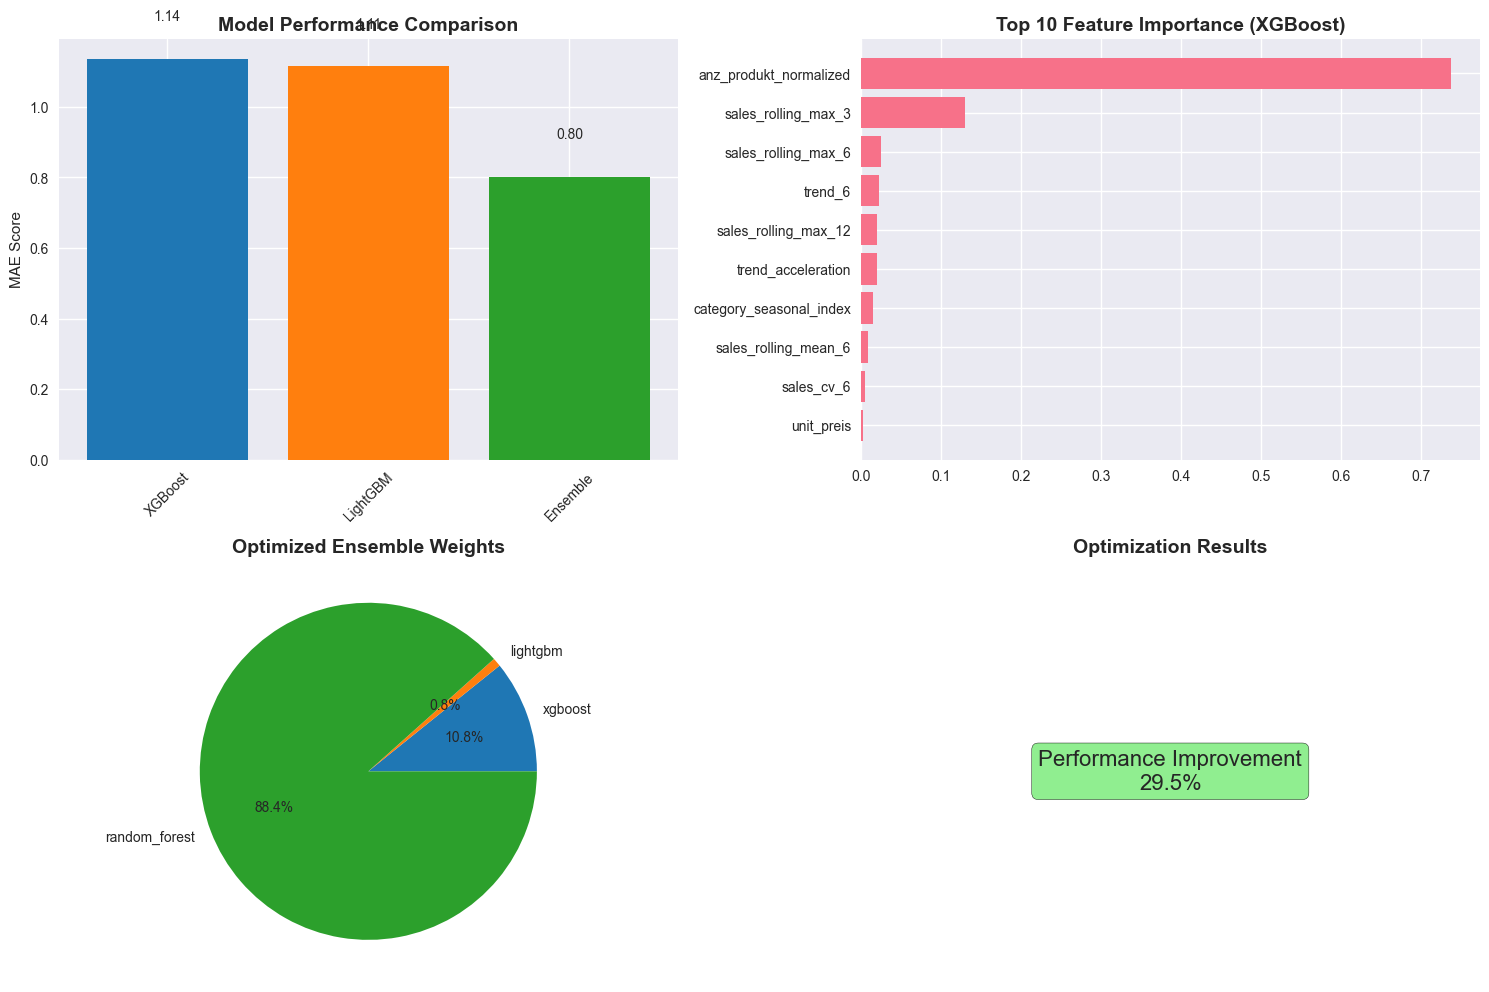

In [24]:
# 8. RESULTS VISUALIZATION
# Visualize optimization results and model performance

def plot_optimization_results():
    """Plot hyperparameter optimization results"""
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Model comparison
    models = ['XGBoost', 'LightGBM', 'Ensemble']
    scores = [xgb_best_score, lgb_best_score, ensemble_best_score]
    
    bars = axes[0, 0].bar(models, scores, color=['#1f77b4', '#ff7f0e', '#2ca02c'])
    axes[0, 0].set_title('Model Performance Comparison', fontsize=14, fontweight='bold')
    axes[0, 0].set_ylabel('MAE Score')
    axes[0, 0].tick_params(axis='x', rotation=45)
    
    # Add value labels on bars
    for bar, score in zip(bars, scores):
        axes[0, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, 
                        f'{score:.2f}', ha='center', va='bottom')
    
    # Feature importance
    xgb_importance = trained_models['xgboost'].feature_importances_
    feature_names = X_optimized.columns
    
    top_features = np.argsort(xgb_importance)[-10:]
    y_pos = np.arange(len(top_features))
    axes[0, 1].barh(y_pos, xgb_importance[top_features])
    axes[0, 1].set_yticks(y_pos)
    axes[0, 1].set_yticklabels([feature_names[i] for i in top_features])
    axes[0, 1].set_title('Top 10 Feature Importance (XGBoost)', fontsize=14, fontweight='bold')
    
    # Ensemble weights
    axes[1, 0].pie(best_weights.values(), labels=best_weights.keys(), autopct='%1.1f%%',
                   colors=['#1f77b4', '#ff7f0e', '#2ca02c'])
    axes[1, 0].set_title('Optimized Ensemble Weights', fontsize=14, fontweight='bold')
    
    # Performance improvement
    baseline_score = max(xgb_best_score, lgb_best_score)
    improvement = (baseline_score - ensemble_best_score) / baseline_score * 100
    
    axes[1, 1].text(0.5, 0.5, f'Performance Improvement\n{improvement:.1f}%', 
                   ha='center', va='center', fontsize=16, 
                   bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgreen"))
    axes[1, 1].set_xlim(0, 1)
    axes[1, 1].set_ylim(0, 1)
    axes[1, 1].axis('off')
    axes[1, 1].set_title('Optimization Results', fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.show()

# Plot results
plot_optimization_results()

## 9. Save Optimized Configuration

In [26]:
# 9. SAVE OPTIMIZED CONFIGURATION
# Save the best hyperparameters for production use

def save_optimized_config():
    """Save optimized configuration for production"""
    
    optimized_config = {
        'feature_selection': {
            'selected_features': optimized_features,
            'max_features': len(optimized_features)
        },
        'model_hyperparameters': {
            'xgboost': xgb_best_params,
            'lightgbm': lgb_best_params,
            'random_forest': {
                'n_estimators': 200,
                'max_depth': 10,
                'random_state': 42
            }
        },
        'ensemble_weights': best_weights,
        'performance_metrics': {
            'xgboost_mae': xgb_best_score,
            'lightgbm_mae': lgb_best_score,
            'ensemble_mae': ensemble_best_score,
            'improvement_percent': ((max(xgb_best_score, lgb_best_score) - ensemble_best_score) / 
                                  max(xgb_best_score, lgb_best_score) * 100)
        },
        'optimization_metadata': {
            'sample_size': len(sample_data),
            'feature_count': len(feature_columns),
            'optimization_date': pd.Timestamp.now().isoformat()
        }
    }
    
    # Save to JSON
    import json
    with open('optimized_hyperparameters.json', 'w') as f:
        json.dump(optimized_config, f, indent=2, default=str)
    
    print("💾 Optimized configuration saved to config/optimized_hyperparameters.json")
    
    return optimized_config

# Save configuration
config = save_optimized_config()

# Display summary
print("\n" + "="*60)
print("�� HYPERPARAMETER OPTIMIZATION SUMMARY")
print("="*60)
print(f"📊 Sample data size: {len(sample_data):,} records")
print(f"🔧 Features selected: {len(optimized_features)}")
print(f"�� XGBoost MAE: {xgb_best_score:.2f}")
print(f"�� LightGBM MAE: {lgb_best_score:.2f}")
print(f"📈 Ensemble MAE: {ensemble_best_score:.2f}")
print(f"🚀 Performance improvement: {config['performance_metrics']['improvement_percent']:.1f}%")
print(f"⚖️  Best ensemble weights: {best_weights}")
print("="*60)

💾 Optimized configuration saved to config/optimized_hyperparameters.json

�� HYPERPARAMETER OPTIMIZATION SUMMARY
📊 Sample data size: 160,874 records
🔧 Features selected: 15
�� XGBoost MAE: 1.14
�� LightGBM MAE: 1.11
📈 Ensemble MAE: 0.80
🚀 Performance improvement: 29.5%
⚖️  Best ensemble weights: {'xgboost': 0.10793173639787616, 'lightgbm': 0.008247804067011507, 'random_forest': 0.8838204595351122}


## 10. Production Integration

In [27]:
# 10. PRODUCTION INTEGRATION
# Show how to use optimized parameters in the main application

def create_optimized_ensemble_model():
    """Create ensemble model with optimized parameters"""
    
    from models.ensemble_model import EnsembleForecaster
    
    # Create optimized model configuration
    optimized_models_config = {
        "xgboost": xgb_best_params,
        "lightgbm": lgb_best_params,
        "random_forest": {
            "n_estimators": 200,
            "max_depth": 10,
            "random_state": 42,
            "n_jobs": -1,
        }
    }
    
    # Create ensemble with optimized config
    ensemble = EnsembleForecaster(models_config=optimized_models_config)
    
    print("✅ Optimized ensemble model created!")
    print("🔧 Configuration:")
    for model, params in optimized_models_config.items():
        print(f"   {model}: {params}")
    
    return ensemble

# Create optimized model
optimized_ensemble = create_optimized_ensemble_model()

print("\n�� Ready for production training with optimized hyperparameters!")
print("📋 Next steps:")
print("   1. Use optimized_hyperparameters.json in your main application")
print("   2. Train on full dataset with these parameters")
print("   3. Monitor performance in production")
print("   4. Set up automated retraining with optimized parameters")

✅ Optimized ensemble model created!
🔧 Configuration:
   xgboost: {'n_estimators': 303, 'max_depth': 10, 'learning_rate': 0.10487662447025792, 'subsample': 0.8493831368447333, 'colsample_bytree': 0.9578410352643851, 'reg_alpha': 9.18598441463103, 'reg_lambda': 5.51968716245559}
   lightgbm: {'n_estimators': 499, 'max_depth': 9, 'learning_rate': 0.1594880549905189, 'num_leaves': 64, 'subsample': 0.829623127594056, 'colsample_bytree': 0.9945381025198837, 'reg_alpha': 8.791421648929509, 'reg_lambda': 4.532145933162949}
   random_forest: {'n_estimators': 200, 'max_depth': 10, 'random_state': 42, 'n_jobs': -1}

�� Ready for production training with optimized hyperparameters!
📋 Next steps:
   1. Use optimized_hyperparameters.json in your main application
   2. Train on full dataset with these parameters
   3. Monitor performance in production
   4. Set up automated retraining with optimized parameters
